# Build data sets for ML tasks

In [1]:
# Imports
import pandas as pd
import numpy as np
import csv
import os
from random import randint

In [2]:
p_pairs = []
with open('Cited_Pairs.csv', newline="\n") as f:
    reader = csv.reader(f, delimiter='\t')
    for i, row in enumerate(reader):
        if i > 0:
            p_pairs.append(row)
            # [paper cited, citing paper, paper cited abstract, citing paper abstract, is_Citation: bool]
            p_pairs[-1].append(True)

In [3]:
citing_ids = []
for pair in p_pairs:
    citing_ids.append(pair[1])
print(len(set(citing_ids)))
print(citing_ids)

691
['13548556499559547747', '7817802389471101066', '2745806242339894212', '17113238684157646538', '8327272796520095610', '3129578775481411450', '11964839206980330302', '15739826139411049723', '17831363954201391315', '16177009705954697270', '18057799461298019724', '17732528558474230529', '18269712752613491981', '17640966541520339359', '18254688514657241561', '8976487770990178044', '12855937004888359241', '15932869302045479284', '15534867282904611259', '14463827318916201642', '5955154734179538060', '2513817392871895261', '15338476863286458867', '9594363440986743954', '11333084215770352793', '6577836571022267532', '3245338741531238399', '17106367144862843251', '16468976420758583782', '17090379372318509131', '2217531809037519936', '6796320317161997444', '16177009705954697270', '3140069985091518864', '1924844430929739761', '14357281698020734146', '16275671468232651075', '16468976420758583782', '291081045988684859', '7950617852621047574', '17024169331315256063', '14404528281869175045', '265

In [4]:
n_pairs = []
with open('Not_Cited_Pairs.csv', newline="\n") as f:
    reader = csv.reader(f, delimiter='\t')
    for i, row in enumerate(reader):
        if i > 0:
            n_pairs.append(row)
            # [paper cited, citing paper, paper cited abstract, citing paper abstract, is_Citation: bool]
            n_pairs[-1].append(False)

In [5]:
# Train 60 %, val 20 %, test 20 % split
from sklearn.model_selection import train_test_split
for p in p_pairs:
    if len(p) != 5:
        print(len(p))
        print(p)
p_df = pd.DataFrame(p_pairs, columns=["paper_cited", "citing_paper", "paper_cited_abstract", "citing_paper_abstract", "is_citation"])
n_df = pd.DataFrame(n_pairs, columns=["paper_cited", "citing_paper", "paper_cited_abstract", "citing_paper_abstract", "is_citation"])
df = pd.concat([p_df, n_df])
train_pairs, val_test_pairs = train_test_split(df, shuffle=True, stratify=df[["is_citation"]], train_size=0.6, random_state=0)
val_pairs, test_pairs = train_test_split(val_test_pairs, shuffle=True, stratify=val_test_pairs[["is_citation"]], train_size=0.5, random_state=0)
print("{} Train pairs\n{} Validation pairs\n{} Test pairs".format(train_pairs.shape[0], val_pairs.shape[0], test_pairs.shape[0]))

2408 Train pairs
803 Validation pairs
803 Test pairs


# TF-IDF Similarity

In [6]:
# Calculate similarity for each pair
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(stop_words='english')
train_abstracts_list = []

for i in range(train_pairs.shape[0]):
    train_abstracts_list.append(train_pairs.iloc[i].paper_cited_abstract)

# Learn vocabulary and idf, return term-document matrix.
tfidf = vectorizer.fit(train_abstracts_list)
#print(tfidf.vocabulary_)

def calculate_similarities(pairs_list, tfidf_vectorizer):
    similarities = []
    for i in range(pairs_list.shape[0]):
        a1 = pairs_list.iloc[i].paper_cited_abstract
        a2 = pairs_list.iloc[i].citing_paper_abstract
        similarities.append(cosine_similarity(tfidf_vectorizer.transform([a1]), tfidf_vectorizer.transform([a2]))[0])
    return similarities

train_similarities = calculate_similarities(train_pairs, vectorizer)
val_similarities = calculate_similarities(val_pairs, vectorizer)
test_similarities = calculate_similarities(test_pairs, vectorizer)

In [7]:
# Check correlation between similarity and existance of citation
from sklearn.linear_model import LinearRegression
reg = LinearRegression(n_jobs=0).fit(train_similarities, train_pairs["is_citation"].values)
print("Linear regression based on cosine similarity of TF-IDF")
print("\nTraining data:")
print("Score as Coefficient of determination of the prediction:", reg.score(train_similarities, train_pairs.is_citation))
print("Cosine similarity coefficient:", reg.coef_)
print("\nValidation data:")
print("Score as Coefficient of determination of the prediction:", reg.score(val_similarities, val_pairs.is_citation))
print("Cosine similarity coefficient:", reg.coef_)
print("\nTest data:")
print("Score as Coefficient of determination of the prediction:", reg.score(test_similarities, test_pairs.is_citation))
print("Cosine similarity coefficient:", reg.coef_)

Linear regression based on cosine similarity of TF-IDF

Training data:
Score as Coefficient of determination of the prediction: 0.325287254059889
Cosine similarity coefficient: [2.51829924]

Validation data:
Score as Coefficient of determination of the prediction: 0.3455740741336317
Cosine similarity coefficient: [2.51829924]

Test data:
Score as Coefficient of determination of the prediction: 0.3670181681666337
Cosine similarity coefficient: [2.51829924]


In [8]:
train_y = train_pairs["is_citation"].values
train_y = [float(1) if y else float(0) for y in train_y]
val_y = val_pairs["is_citation"].values
val_y = [float(1) if y else float(0) for y in val_y]
test_y = test_pairs["is_citation"].values
test_y = [float(1) if y else float(0) for y in test_y]

## Pre-Trained BERT Embeddings for abstracts

In [9]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

In [10]:
import seaborn as sns
from sklearn.metrics import pairwise

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.

In [11]:
#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/pubmed/2" # @param {type: "string"} ["https://tfhub.dev/google/experts/bert/wiki_books/2", "https://tfhub.dev/google/experts/bert/wiki_books/mnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qqp/2", "https://tfhub.dev/google/experts/bert/wiki_books/squad2/2", "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",  "https://tfhub.dev/google/experts/bert/pubmed/2", "https://tfhub.dev/google/experts/bert/pubmed/squad2/2"]
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [12]:
def embed_pairs(pairs, preprocess, model):
    embedded_pairs = []
    for i in range(pairs.shape[0]):
        a1 = preprocess([pairs.iloc[i].paper_cited_abstract])
        a2 = preprocess([pairs.iloc[i].citing_paper_abstract])
        a1 = bert(a1)
        a2 = bert(a2)
        embedded_pairs.append([a1, a2])
    return embedded_pairs

def calculate_similarities(embedded_pairs):
    similarities = []
    for pair in embedded_pairs:
        similarities.append(pairwise.cosine_similarity(pair[0]["pooled_output"], Y=pair[1]["pooled_output"]))
    return similarities

In [13]:
import re
preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)

In [14]:
# Computationally expensive
# Using only first 100 papers from each set
train_embedded_pairs = embed_pairs(train_pairs[0:100], preprocess, bert)
val_embedded_pairs = embed_pairs(val_pairs[0:100], preprocess, bert)
test_embedded_pairs = embed_pairs(test_pairs[0:100], preprocess, bert)

In [15]:
#bert_train_similarities = []
#for pair in train_embedded_pairs:
#    bert_train_similarities.append(pairwise.cosine_similarity(pair[0]["pooled_output"], Y=pair[1]["pooled_output"]))
bert_train_similarities = calculate_similarities(train_embedded_pairs)
bert_val_similarities = calculate_similarities(val_embedded_pairs)
bert_test_similarities = calculate_similarities(test_embedded_pairs)

In [16]:
print(bert_train_similarities[0])
bert_train_similarities = [i[0] for i in bert_train_similarities]
bert_val_similarities = [i[0] for i in bert_val_similarities]
bert_test_similarities = [i[0] for i in bert_test_similarities]
print(bert_train_similarities[0])

[[0.74229413]]
[0.74229413]


In [17]:
# Check correlation between similarity and existance of citation
from sklearn.linear_model import LinearRegression
reg = LinearRegression(n_jobs=0).fit(bert_train_similarities, train_y[0:100])
print("Linear regression based on cosine similarity of BERT embeddings")
print("\nTraining data:")
print("Score as Coefficient of determination of the prediction:", reg.score(bert_train_similarities, train_y[0:100]))
print("Cosine similarity coefficient:", reg.coef_)
print("\nValidation data:")
print("Score as Coefficient of determination of the prediction:", reg.score(bert_val_similarities, val_y[0:100]))
print("Cosine similarity coefficient:", reg.coef_)
print("\nTest data:")
print("Score as Coefficient of determination of the prediction:", reg.score(bert_test_similarities, test_y[0:100]))
print("Cosine similarity coefficient:", reg.coef_)

Linear regression based on cosine similarity of BERT embeddings

Training data:
Score as Coefficient of determination of the prediction: 0.061763411596630124
Cosine similarity coefficient: [0.40251186]

Validation data:
Score as Coefficient of determination of the prediction: -0.07795664995272089
Cosine similarity coefficient: [0.40251186]

Test data:
Score as Coefficient of determination of the prediction: 0.0002729113500563596
Cosine similarity coefficient: [0.40251186]


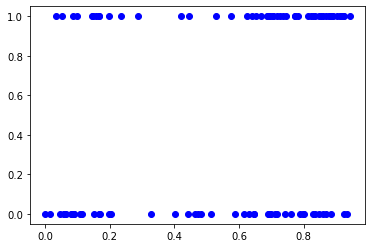

In [18]:
import matplotlib.pyplot as plt
plt.plot(bert_train_similarities, train_y[0:100], 'bo')
plt.show()

# Transfer Learning with SBERT

## Limited manual hyperparameter tuning was only performed due to time and computation resource constraints. 

In [19]:
#!pip install -U sentence-transformers

In [21]:
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, util
from torch.utils.data import DataLoader

model = SentenceTransformer('all-mpnet-base-v2')

train_examples = [InputExample(texts=[train_pairs.iloc[i].paper_cited_abstract, train_pairs.iloc[i].citing_paper_abstract], label=train_y[i]) for i in range(train_pairs.shape[0])]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)
train_loss = losses.CosineSimilarityLoss(model)

abstract1_list = [val_pairs.iloc[i].paper_cited_abstract for i in range(val_pairs.shape[0])]
abstract2_list = [val_pairs.iloc[i].citing_paper_abstract for i in range(val_pairs.shape[0])]
val_evaluator = evaluation.EmbeddingSimilarityEvaluator(abstract1_list, abstract2_list, val_y)

model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=5, warmup_steps=15, evaluator=val_evaluator, evaluation_steps=40, save_best_model=True, output_path=os.getcwd())

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

Iteration:   0%|          | 0/76 [00:00<?, ?it/s]

# Evaluation of model after the final epoch

## The model that performed best on the validation data set was saved to file. Evaluation of that model follows later, with a lot of duplicate code but different results.

In [24]:
train_embedded_pairs = []
for i in range(train_pairs.shape[0]):
    a1 = model.encode([train_pairs.iloc[i].paper_cited_abstract])
    a2 = model.encode([train_pairs.iloc[i].citing_paper_abstract])
    train_embedded_pairs.append([a1, a2])
    
val_embedded_pairs = []
for i in range(val_pairs.shape[0]):
    a1 = model.encode([val_pairs.iloc[i].paper_cited_abstract])
    a2 = model.encode([val_pairs.iloc[i].citing_paper_abstract])
    val_embedded_pairs.append([a1, a2])

test_embedded_pairs = []
for i in range(test_pairs.shape[0]):
    a1 = model.encode([test_pairs.iloc[i].paper_cited_abstract])
    a2 = model.encode([test_pairs.iloc[i].citing_paper_abstract])
    test_embedded_pairs.append([a1, a2])

In [25]:
bert_train_similarities = []
for pair in train_embedded_pairs:
    bert_train_similarities.append(pairwise.cosine_similarity(pair[0], Y=pair[1]))
    
bert_val_similarities = []
for pair in val_embedded_pairs:
    bert_val_similarities.append(pairwise.cosine_similarity(pair[0], Y=pair[1]))
    
bert_test_similarities = []
for pair in test_embedded_pairs:
    bert_test_similarities.append(pairwise.cosine_similarity(pair[0], Y=pair[1]))
    
print(bert_train_similarities[0])
bert_train_similarities = [i[0] for i in bert_train_similarities]
print(bert_train_similarities[0])

bert_val_similarities = [i[0] for i in bert_val_similarities]
print(bert_val_similarities[0])
bert_test_similarities = [i[0] for i in bert_test_similarities]
print(bert_test_similarities[0])

[[0.17819664]]
[0.17819664]
[0.3671897]
[0.8519546]


In [26]:
# Check correlation between similarity and existance of citation
from sklearn.linear_model import LinearRegression
reg = LinearRegression(n_jobs=0).fit(bert_train_similarities, train_y)
print("Linear regression based on cosine similarity of SBERT embeddings\n")
print("Train data")
print("Score as Coefficient of determination of the prediction:", reg.score(bert_train_similarities, train_y))
print("Cosine similarity coefficient:", reg.coef_)

# Linear regression is only fitted on the training data, but depending on what information is wanted it can be done
# for each data set separately
#reg = LinearRegression(n_jobs=0).fit(bert_val_similarities, val_y)
print("\nValidation data")
print("Score as Coefficient of determination of the prediction:", reg.score(bert_val_similarities, val_y))
print("Cosine similarity coefficient:", reg.coef_)

#reg = LinearRegression(n_jobs=0).fit(bert_test_similarities, test_y)
print("\nTest data")
print("Score as Coefficient of determination of the prediction:", reg.score(bert_test_similarities, test_y))
print("Cosine similarity coefficient:", reg.coef_)

Linear regression based on cosine similarity of SBERT embeddings

Train data
Score as Coefficient of determination of the prediction: 0.9135335260825961
Cosine similarity coefficient: [1.1119326]

Validation data
Score as Coefficient of determination of the prediction: 0.6729168414681239
Cosine similarity coefficient: [1.1119326]

Test data
Score as Coefficient of determination of the prediction: 0.7570567820025542
Cosine similarity coefficient: [1.1119326]


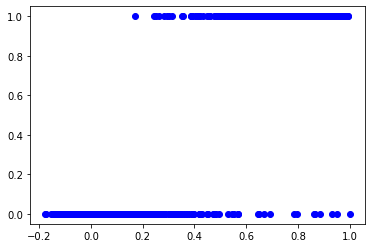

In [27]:
import matplotlib.pyplot as plt
plt.plot(bert_train_similarities, train_y, 'bo')
plt.show()

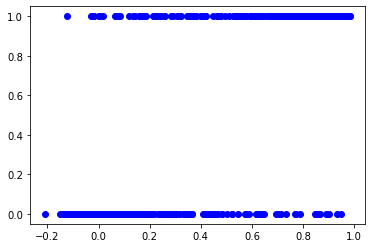

In [28]:
plt.plot(bert_val_similarities, val_y, 'bo')
plt.show()

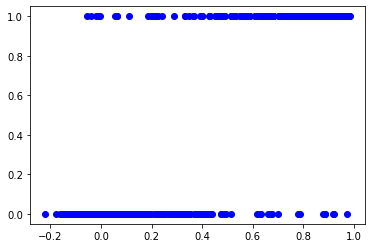

In [29]:
plt.plot(bert_test_similarities, test_y, 'bo')
plt.show()

In [30]:
# Build linear classifier that classifies pairs of papers based on the similarity of embeddings created by SBERT
from sklearn.linear_model import LogisticRegression

linear_classifier = LogisticRegression(random_state=0).fit(bert_train_similarities, train_y)

print("Linear classifier fitted on the training data")
print("Accuracy on training data:", linear_classifier.score(bert_train_similarities, train_y))
print("Accuracy on validation data:", linear_classifier.score(bert_val_similarities, val_y))
print("Accuracy on test data:", linear_classifier.score(bert_test_similarities, test_y))

Linear classifier fitted on the training data
Accuracy on training data: 0.9821428571428571
Accuracy on validation data: 0.8978829389788294
Accuracy on test data: 0.9364881693648817


Train data results:


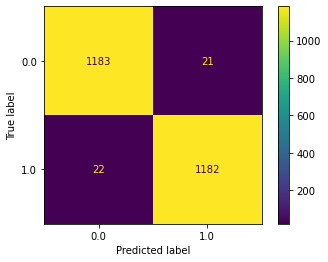

Validation data results:


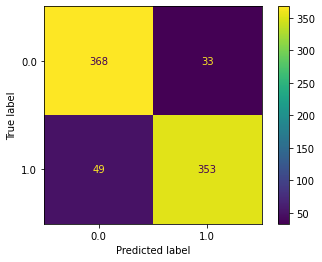

Test data results:


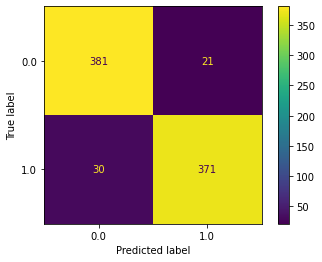

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
print("Train data results:")
ConfusionMatrixDisplay.from_estimator(linear_classifier, bert_train_similarities, train_y)
plt.show()
print("Validation data results:")
ConfusionMatrixDisplay.from_estimator(linear_classifier, bert_val_similarities, val_y)
plt.show()
print("Test data results:")
ConfusionMatrixDisplay.from_estimator(linear_classifier, bert_test_similarities, test_y)
plt.show()

## Best performing model was saved to file, load it to evaluate it

In [32]:
from sentence_transformers import SentenceTransformer, models
model = SentenceTransformer(os.getcwd())

In [33]:
train_embedded_pairs = []
for i in range(train_pairs.shape[0]):
    a1 = model.encode([train_pairs.iloc[i].paper_cited_abstract])
    a2 = model.encode([train_pairs.iloc[i].citing_paper_abstract])
    train_embedded_pairs.append([a1, a2])
    
val_embedded_pairs = []
for i in range(val_pairs.shape[0]):
    a1 = model.encode([val_pairs.iloc[i].paper_cited_abstract])
    a2 = model.encode([val_pairs.iloc[i].citing_paper_abstract])
    val_embedded_pairs.append([a1, a2])

test_embedded_pairs = []
for i in range(test_pairs.shape[0]):
    a1 = model.encode([test_pairs.iloc[i].paper_cited_abstract])
    a2 = model.encode([test_pairs.iloc[i].citing_paper_abstract])
    test_embedded_pairs.append([a1, a2])

In [34]:
from sklearn.metrics import pairwise
bert_train_similarities = []
for pair in train_embedded_pairs:
    bert_train_similarities.append(pairwise.cosine_similarity(pair[0], Y=pair[1]))
    
bert_val_similarities = []
for pair in val_embedded_pairs:
    bert_val_similarities.append(pairwise.cosine_similarity(pair[0], Y=pair[1]))
    
bert_test_similarities = []
for pair in test_embedded_pairs:
    bert_test_similarities.append(pairwise.cosine_similarity(pair[0], Y=pair[1]))
    
print(bert_train_similarities[0])
bert_train_similarities = [i[0] for i in bert_train_similarities]
print(bert_train_similarities[0])

bert_val_similarities = [i[0] for i in bert_val_similarities]
print(bert_val_similarities[0])
bert_test_similarities = [i[0] for i in bert_test_similarities]
print(bert_test_similarities[0])

[[0.13980973]]
[0.13980973]
[0.29741493]
[0.76887995]


In [35]:
# Check correlation between similarity and existance of citation
from sklearn.linear_model import LinearRegression
reg = LinearRegression(n_jobs=0).fit(bert_train_similarities, train_y)
print("Linear regression based on cosine similarity of SBERT embeddings\n")
print("Train data")
print("Score as Coefficient of determination of the prediction:", reg.score(bert_train_similarities, train_y))
print("Cosine similarity coefficient:", reg.coef_)

#reg = LinearRegression(n_jobs=0).fit(bert_val_similarities, val_y)
print("\nValidation data")
print("Score as Coefficient of determination of the prediction:", reg.score(bert_val_similarities, val_y))
print("Cosine similarity coefficient:", reg.coef_)

#reg = LinearRegression(n_jobs=0).fit(bert_test_similarities, test_y)
print("\nTest data")
print("Score as Coefficient of determination of the prediction:", reg.score(bert_test_similarities, test_y))
print("Cosine similarity coefficient:", reg.coef_)

Linear regression based on cosine similarity of SBERT embeddings

Train data
Score as Coefficient of determination of the prediction: 0.831422939616097
Cosine similarity coefficient: [1.1263859]

Validation data
Score as Coefficient of determination of the prediction: 0.6937799517227023
Cosine similarity coefficient: [1.1263859]

Test data
Score as Coefficient of determination of the prediction: 0.7561946526370791
Cosine similarity coefficient: [1.1263859]


In [36]:
# Build linear classifier that classifies pairs of papers based on the similarity of embeddings created by SBERT
from sklearn.linear_model import LogisticRegression

linear_classifier = LogisticRegression(random_state=0).fit(bert_train_similarities, train_y)

print("Linear classifier fitted on the training data")
print("Accuracy on training data:", linear_classifier.score(bert_train_similarities, train_y))
print("Accuracy on validation data:", linear_classifier.score(bert_val_similarities, val_y))
print("Accuracy on test data:", linear_classifier.score(bert_test_similarities, test_y))

Linear classifier fitted on the training data
Accuracy on training data: 0.9551495016611296
Accuracy on validation data: 0.9078455790784558
Accuracy on test data: 0.933997509339975


Train data results:


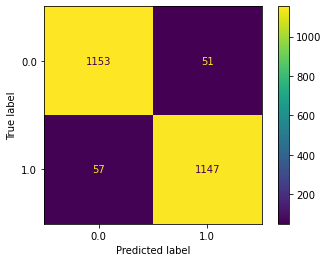

Validation data results:


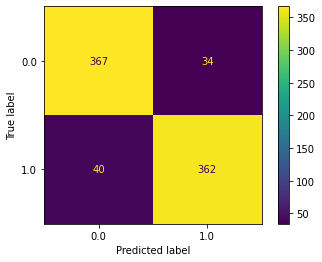

Test data results:


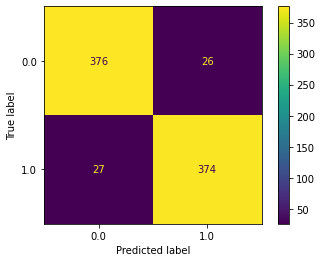

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
print("Train data results:")
ConfusionMatrixDisplay.from_estimator(linear_classifier, bert_train_similarities, train_y)
plt.show()
print("Validation data results:")
ConfusionMatrixDisplay.from_estimator(linear_classifier, bert_val_similarities, val_y)
plt.show()
print("Test data results:")
ConfusionMatrixDisplay.from_estimator(linear_classifier, bert_test_similarities, test_y)
plt.show()

In [38]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
def print_metrics(dataset_name, predictions, true_labels):
    print(dataset_name, "accuracy:", accuracy_score(true_labels, predictions))
    print(dataset_name, "recall:", recall_score(true_labels, predictions))
    print(dataset_name, "precision:", precision_score(true_labels, predictions))
    print(dataset_name, "f1 score:", f1_score(true_labels, predictions), end="\n\n")
    
print_metrics("Training", linear_classifier.predict(bert_train_similarities), train_y)
print_metrics("Validation", linear_classifier.predict(bert_val_similarities), val_y)
print_metrics("Testing", linear_classifier.predict(bert_test_similarities), test_y)

Training accuracy: 0.9551495016611296
Training recall: 0.9526578073089701
Training precision: 0.9574290484140233
Training f1 score: 0.9550374687760198

Validation accuracy: 0.9078455790784558
Validation recall: 0.900497512437811
Validation precision: 0.9141414141414141
Validation f1 score: 0.9072681704260651

Testing accuracy: 0.933997509339975
Testing recall: 0.9326683291770573
Testing precision: 0.935
Testing f1 score: 0.933832709113608



In [39]:
# Check most similar abstracts out of 500 first
# Load all abstracts
excel_filename = "Abstract"
abstract_df = pd.read_excel(excel_filename + ".xls")
#Encode first 500 abstracts
embeddings = model.encode(abstract_df.Abstract.to_list()[0:500])

#Compute cosine similarity between all pairs
cos_sim = util.cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_sentence_combinations[0:5]:
    print("{} \n\n {} \n\n\n {:.4f}".format(abstract_df.Abstract.to_list()[i], abstract_df.Abstract.to_list()[j], cos_sim[i][j]))

Top-5 most similar pairs:
nan 

 nan 


 1.0000
Fault diagnosis of rotating machinery plays a significant role for the reliability and safety of modern industrial systems. As an emerging field in industrial applications and an effective solution for fault recognition, artificial intelligence (AI) techniques have been receiving increasing attention from academia and industry. However, great challenges are met by the AI methods under the different real operating conditions. This paper attempts to present a comprehensive review of AI algorithms in rotating machinery fault diagnosis, from both the views of theory background and industrial applications. A brief introduction of different AI algorithms is presented first, including the following methods: k-nearest neighbour, naive Bayes, support vector machine, artificial neural network and deep learning. Then, a broad literature survey of these AI algorithms in industrial applications is given. Finally, the advantages, limitations, practical

## Search most similar abstract with the trained SBERT model 

## NOTE: A different search algorithm is used with the actual search engine

In [40]:
N_NEAREST = 5

abstract_to_search = """Objective: The aim of this review was to summarize major topics in artificial intelligence (AI), including their applications and limitations in surgery. This paper reviews the key capabilities of AI to help surgeons understand and critically evaluate new AI applications and to contribute to new developments. Summary Background Data: AI is composed of various subfields that each provide potential solutions to clinical problems. Each of the core subfields of AI reviewed in this piece has also been used in other industries such as the autonomous car, social networks, and deep learning computers. Methods: A review of AI papers across computer science, statistics, and medical sources was conducted to identify key concepts and techniques within AI that are driving innovation across industries, including surgery. Limitations and challenges of working with AI were also reviewed. Results: Four main subfields of AI were defined: (1) machine learning, (2) artificial neural networks, (3) natural language processing, and (4) computer vision. Their current and future applications to surgical practice were introduced, including big data analytics and clinical decision support systems. The implications of AI for surgeons and the role of surgeons in advancing the technology to optimize clinical effectiveness were discussed. Conclusions: Surgeons are well positioned to help integrate AI into modern practice. Surgeons should partner with data scientists to capture data across phases of care and to provide clinical context, for AI has the potential to revolutionize the way surgery is taught and practiced with the promise of a future optimized for the highest quality patient care.."""

abstract_to_search_embedded = model.encode([abstract_to_search])

similarities = []
for abstract in embeddings:
  similarities.append(util.cos_sim(abstract_to_search_embedded, abstract))

abstracts_list = abstract_df.Abstract.to_list()
most_similar_indexes = []
print("The abstract given:")
print(abstract_to_search)
for i in range(N_NEAREST):
    print("\nThe {}. most similar abstract:".format(i + 1))
    index = similarities.index(max(similarities))
    most_similar_indexes.append(index)
    print(abstracts_list[index])
    del abstracts_list[index]
    del similarities[index]

The abstract given:
Objective: The aim of this review was to summarize major topics in artificial intelligence (AI), including their applications and limitations in surgery. This paper reviews the key capabilities of AI to help surgeons understand and critically evaluate new AI applications and to contribute to new developments. Summary Background Data: AI is composed of various subfields that each provide potential solutions to clinical problems. Each of the core subfields of AI reviewed in this piece has also been used in other industries such as the autonomous car, social networks, and deep learning computers. Methods: A review of AI papers across computer science, statistics, and medical sources was conducted to identify key concepts and techniques within AI that are driving innovation across industries, including surgery. Limitations and challenges of working with AI were also reviewed. Results: Four main subfields of AI were defined: (1) machine learning, (2) artificial neural ne